In [1]:
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np
import IPython.display as ipd
from tqdm import *
import random

import librosa
import librosa.display
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import *
from torchvision.transforms import *
from torch.autograd import Variable

%matplotlib inline

In [2]:
SAMPLE_RATE = 16000

TRAIN_PATH = 'tf_speech_data/train'
TEST_PATH = 'tf_speech_data/test/audio'
classes = os.listdir(f'{TRAIN_PATH}/train')

x, y = [], []
for c in classes:
    files = os.listdir(f'{TRAIN_PATH}/train/{c}')
    if(c != '_background_noise_'):
        x.append(c)
        y.append(len(files))

In [3]:
def random_soundfile(mainpath, cls): return mainpath + cls + '/' + np.random.choice(os.listdir(mainpath + cls))

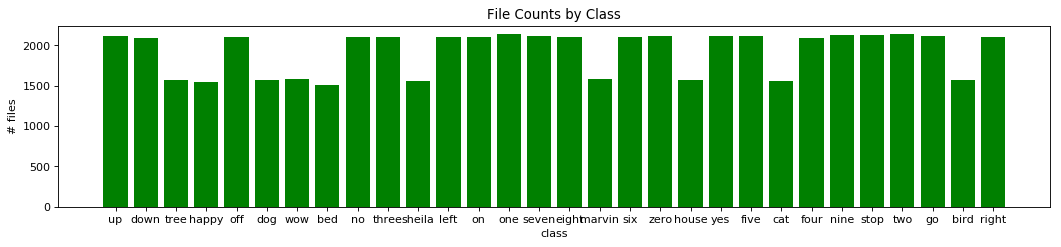

In [4]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 3), dpi=80, facecolor='w', edgecolor='k')

x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y, color='green')
plt.xlabel("class")
plt.ylabel("# files")
plt.title("File Counts by Class")

plt.xticks(x_pos, x)

plt.show()

A .wav file is just a numpy array of floats.  Much less scary to think about.

In [5]:
cls = 'five'
filename = random_soundfile(f'{TRAIN_PATH}/train/', cls)
samples, sample_rate = librosa.load(filename, 16000)

In [6]:
samples

array([-0.00778198, -0.01504517, -0.00787354, ..., -0.0083313 ,
       -0.01062012, -0.01010132], dtype=float32)

The sample rate is the # of measurements per second to take, and the resulting array is a plot of every measurement over time.  A "sample" is a number (float32 in this case) -- nothing more nothing less.  That number represents the "amplitude" of the measurement.  We experience "amplitude" as loudness, so you can think of the numpy array as this:

__N measurements per second, each capturing the loudness of the clip at that moment in time__

N = SAMPLE_RATE in our case

And in fact we can plot our array w/ time scaled to 1

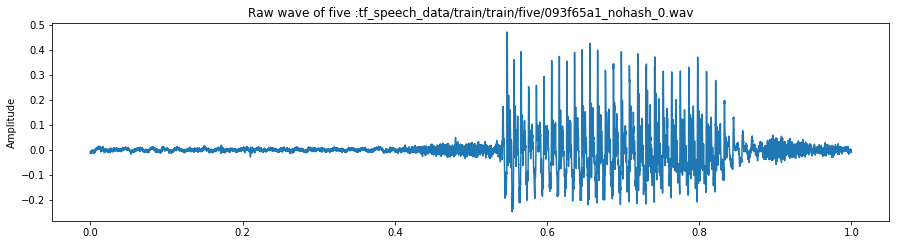

In [7]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(211)
ax1.set_title(f'Raw wave of {cls} :{filename}')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), len(samples)), samples)

Or we can listen to these measurements with our ears.

In [8]:
ipd.Audio(samples, rate=sample_rate)

The very easiest thing we can do is create something called a Log Mel-Scaled Spectrogram & chuck it through a CNN (ResNet for example). A Mel-Scaled Spectrogram creates bins corresponding to pitch and plots the loudness of each pitch over time. I think of this as a piano along the y axis, with time on the x, with "hotter" colors representing higher numbers (i.e. louder). We take the log of this because logs are our friends.

My instinct is that processing raw wav files will prove to be the best option at the end, but in the spirit of trying the easy thing first, this is a good first step because it creates s 32x32 matrix can be easily be processed w/ convolutions.

In [9]:
def wav2logmel(samples, sample_rate):
    s = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=32)
    return librosa.power_to_db(s, ref=np.max)
log_s = wav2logmel(samples, sample_rate)

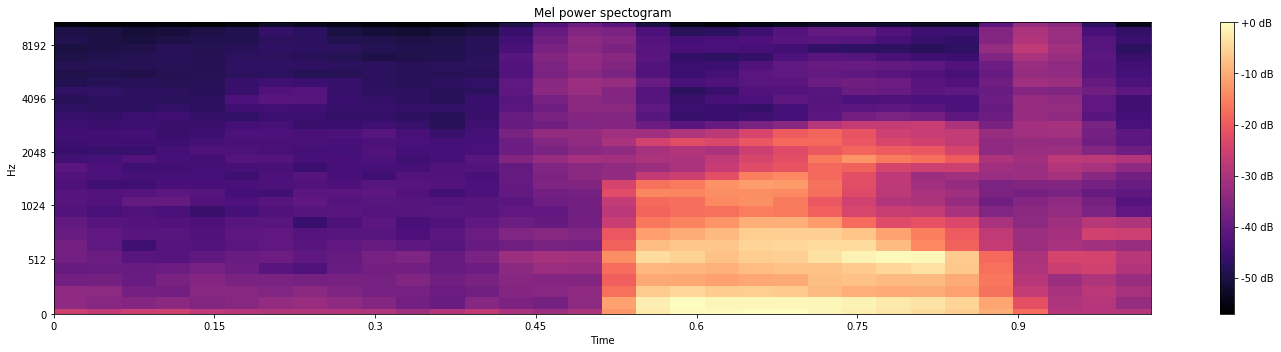

In [10]:
def plot_spectrogram(log_s, sample_rate):
    plt.figure(figsize=(20, 5))
    librosa.display.specshow(log_s, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.title('Mel power spectogram')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

plot_spectrogram(log_s, sample_rate)

In [11]:
log_s.shape

(32, 32)

# Deep Learning
Now we can deep-learn

In [12]:
class AudioDataset(Dataset):
    def __init__(self, path, transform=None):
        NUM_SILENCE_TO_GEN = 1800
        self.transform = transform
        self.classes = [c for c in os.listdir(path) if c != '_background_noise_']
        self.classes.append('silence')
        self.class2ix = {c:i for i,c in enumerate(self.classes)}
        self.data = []
        
        for c in self.classes:
            if c == 'silence':
                silence_id = self.class2ix['silence']
                self.data += [(None, silence_id)] * NUM_SILENCE_TO_GEN
            else:
                d = os.path.join(path, c)
                target = self.class2ix[c]
                for f in os.listdir(d):
                    fname = os.path.join(d, f)
                    self.data.append((fname, target))
        
        self.n = len(self.data)

    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        filename, y = self.data[index]
        if self.transform is not None:
            return self.transform(filename), y 
        return x, y

In [13]:
#[c for c in os.listdir(f'{TRAIN_PATH}/train') if c != '_background_noise_']

The wav2logmel function can be turned into a Python callable, and passed as a transform to our data loader.

In [14]:
class LoadAudio(object):
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate
        
    def __call__(self, path):
        padded = np.zeros((self.sample_rate,))
        if path:
            samples, _ = librosa.load(path, self.sample_rate)
            padded[:samples.shape[0]] = samples
        return padded
        
class Wav2LogMelTensor(object):
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate

    def __call__(self, samples):
        log_s = wav2logmel(samples, self.sample_rate)
        return log_s

#t = Compose([LoadAudio(SAMPLE_RATE), Wav2LogMelTensor(SAMPLE_RATE)])

Next, we need to pipe in background noise

In [15]:
class BackgroundNoiseDataset(Dataset):
    def __init__(self, path, sample_rate=SAMPLE_RATE, num_seconds=1):
        files = [d for d in os.listdir(path) if d.endswith('.wav')]
        samples = []
        for f in files:
            fname = os.path.join(path, f)
            s, sr = librosa.load(fname, sample_rate)
            samples.append(s)

        samples = np.hstack(samples)
        c = int(sample_rate * num_seconds)
        r = len(samples) // c
        self.samples = samples[:r*c].reshape(-1, c)
        self.sample_rate = sample_rate
        self.path = path

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        return self.samples[index]

In [16]:
bgnoise_ds = BackgroundNoiseDataset(f'{TRAIN_PATH}/train/_background_noise_')
ipd.Audio(random.choice(bgnoise_ds), rate=SAMPLE_RATE)

This dataset produces 1 second of background noise, which can then be combined with any other clip.

In [17]:
def combine(wav, noise, pct):
    return wav * (1 - pct) + noise * pct

noise_pct = .50
new = combine(samples, bgnoise_ds[208], noise_pct)
ipd.Audio(new, rate=SAMPLE_RATE)

In [18]:
class AddBackgroundNoise(Dataset):
    def __init__(self, noise_dl, max_percentage=0.45):
        self.bg_dataset = noise_dl
        self.max_percentage = max_percentage

    def __call__(self, clip):
        noise = random.choice(self.bg_dataset)
        percentage = random.uniform(0, self.max_percentage)
        return combine(clip, noise, percentage)

In [ ]:
# this is our final pipeline of transforms:
t = Compose([LoadAudio(SAMPLE_RATE), AddBackgroundNoise(bgnoise_ds), Wav2LogMelTensor(SAMPLE_RATE)])

In [ ]:
train_ds = AudioDataset(f'{TRAIN_PATH}/train', transform=t)
valid_ds = AudioDataset(f'{TRAIN_PATH}/valid', transform=t)
s = RandomSampler(train_ds) ## todo: make this WeightedRandomSampler

train_dl = DataLoader(train_ds, batch_size=98, sampler=s,
                              pin_memory=True, num_workers=4)
valid_dl = DataLoader(train_ds, batch_size=98, pin_memory=True, num_workers=8)

In [ ]:
# batch_x, batch_y = next(iter(train_dl))
# plot_spectrogram(batch_x[0].numpy(), SAMPLE_RATE)

In [ ]:
from models.resnet import resnet34

lr, mo, wd = 0.01, 0.9, 1e-2 ## TODO: optimize
nclass=len(train_ds.classes)

model = resnet34(num_classes=nclass, in_channels=1)
model = torch.nn.DataParallel(model).cuda()

crit = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=mo, weight_decay=wd)

In [ ]:
from util import fit

fit(model, train_dl, valid_dl, crit, optim, num_epochs=10)

  0%|          | 0/59780 [00:00<?, ?audios/s]

1.404647349529579 58.131708052174204


 38%|███▊      | 22834/59780 [01:03<01:41, 362.95audios/s, loss=1.14691, acc=66.00%]

Not bad for a first try!

## Next Steps
My true goal is to determine exactly how much (or how little) data is needed to extend this dataset.  Ideally I would like to build a system in which the developer or user can create a language out of an arbitrary set of words.  The real dream would be for the user to "teach" new words to the model the way we do with pets.

- Hyperparams
    - Implement fastai's lr_find
    - further experimentation: momentum, weight decay, new loss func (adamw?)
- port over the winning code from TF to Pytorch
    - https://github.com/see--/speech_recognition
- try ULMFiT style pre-training by training an acoustic model on LibriSpeech and then fine tuning to this 
- try replacing/augmenting dataset w/ synthetic data generated by a TTS system

## Acknowledgements

This notebook is a synthesis of info from:
- https://github.com/KeremTurgutlu/deeplearning.git
- https://github.com/tugstugi/pytorch-speech-commands
- and of course: http://course.fast.ai/